# Phase 3: Finite-Size Scaling (FSS) Analysis

This notebook analyzes Phase 3 experiment results which test **finite-size scaling** at the critical point.

## Key Questions
- How does the cluster size distribution change with system size L?
- Does the maximum cluster size scale as $s_{max} \sim L^D$ (fractal dimension)?
- Does the largest cluster fraction show critical scaling?

## Theory
At criticality, we expect:
- **Cluster size distribution**: $P(s) \sim s^{-\tau}$ with cutoff at $s_{max}$
- **Maximum cluster size**: $s_{max} \sim L^{D}$ where D is the fractal dimension
- **Order parameter**: $P_\infty \sim L^{-\beta/\nu}$ (largest cluster fraction)

In [1]:
# Setup: Add project root to path and import analysis functions
import sys
from pathlib import Path
import ast

# Add scripts directory to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "scripts"))

# Import analysis functions
from analysis import load_phase3_results, plot_phase3_fss_analysis

# Other imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import json

# Configure matplotlib for notebook display
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['figure.dpi'] = 100

print(f"Project root: {project_root}")
print("✓ Analysis functions imported successfully")


Project root: /Users/saryabou/Documents/GitHub/Complex_Systems_Simulation/CSS_Project
✓ Analysis functions imported successfully


## Load Phase 3 Results

Load the Phase 3 FSS experiment results and examine the data structure.


In [2]:
# Define the path to your Phase 3 results
results_dir = project_root / "hpc_data" / "phase3_18698382"

# Load the results
results = load_phase3_results(results_dir)
print(f"✓ Loaded {len(results)} simulation results")

# Load metadata
with open(results_dir / "phase3_metadata.json") as f:
    metadata = json.load(f)

print(f"\nExperiment Details:")
print(f"  Critical point: prey_birth={metadata['critical_point']['prey_birth']}, "
      f"prey_death={metadata['critical_point']['prey_death']}")
print(f"  Grid sizes: {metadata['grid_sizes']}")
print(f"  Replicates per size: {metadata['n_sims'] // len(metadata['grid_sizes'])}")

# Quick peek at the data structure
print(f"\nSample result keys: {list(results[0].keys())[:10]}...")


✓ Loaded 120 simulation results

Experiment Details:
  Critical point: prey_birth=0.2, prey_death=0.0963
  Grid sizes: [50, 100, 250, 500, 1000, 2500]
  Replicates per size: 20

Sample result keys: ['prey_birth', 'prey_death', 'predator_birth', 'predator_death', 'grid_size', 'with_evolution', 'seed', 'prey_mean', 'prey_std', 'pred_mean']...


In [3]:
# Helper function to parse cluster sizes
def parse_clusters(x):
    if isinstance(x, list):
        return x
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return []
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return []

# Extract data by grid size
grid_sizes = sorted(set(r['grid_size'] for r in results))

# Data structures for analysis
data_by_L = {L: {
    'prey_clusters': [],
    'prey_largest_frac': [],
    'prey_max_cluster': [],
    'prey_n_clusters': [],
    'prey_survived': [],
    'pred_survived': [],
} for L in grid_sizes}

# Collect data
for r in results:
    L = r['grid_size']
    prey_clusters = parse_clusters(r.get('prey_cluster_sizes', []))
    
    data_by_L[L]['prey_clusters'].extend(prey_clusters)
    data_by_L[L]['prey_survived'].append(r.get('prey_survived', False))
    data_by_L[L]['pred_survived'].append(r.get('pred_survived', False))
    
    if r.get('prey_largest_fraction') is not None and not np.isnan(r.get('prey_largest_fraction', np.nan)):
        data_by_L[L]['prey_largest_frac'].append(r['prey_largest_fraction'])
    
    if prey_clusters:
        data_by_L[L]['prey_max_cluster'].append(max(prey_clusters))
        data_by_L[L]['prey_n_clusters'].append(len(prey_clusters))

# Summary by grid size
print("Data Summary by Grid Size:")
print("-" * 70)
print(f"{'L':<8} {'n_runs':<10} {'prey_surv':<12} {'pred_surv':<12} {'s_max (mean)':<15}")
print("-" * 70)
for L in grid_sizes:
    n_runs = len([r for r in results if r['grid_size'] == L])
    prey_surv = np.mean(data_by_L[L]['prey_survived']) * 100
    pred_surv = np.mean(data_by_L[L]['pred_survived']) * 100
    s_max = np.mean(data_by_L[L]['prey_max_cluster']) if data_by_L[L]['prey_max_cluster'] else 0
    print(f"{L:<8} {n_runs:<10} {prey_surv:<12.0f}% {pred_surv:<12.0f}% {s_max:<15.1f}")
print("-" * 70)


Data Summary by Grid Size:
----------------------------------------------------------------------
L        n_runs     prey_surv    pred_surv    s_max (mean)   
----------------------------------------------------------------------
50       20         95          % 10          % 697.6          
100      20         100         % 55          % 1303.2         
250      20         100         % 100         % 2595.6         
500      20         100         % 100         % 3926.1         
1000     20         100         % 100         % 6937.4         
2500     20         100         % 100         % 12288.0        
----------------------------------------------------------------------


## Finite-Size Scaling Plots

Generate the 4-panel FSS analysis figure:
1. **Cluster Size Distributions**: P(s) for each grid size L
2. **Maximum Cluster Scaling**: $s_{max}$ vs L (extract fractal dimension D)
3. **Order Parameter Scaling**: Largest cluster fraction vs L
4. **Cluster Count Scaling**: Number of clusters vs L


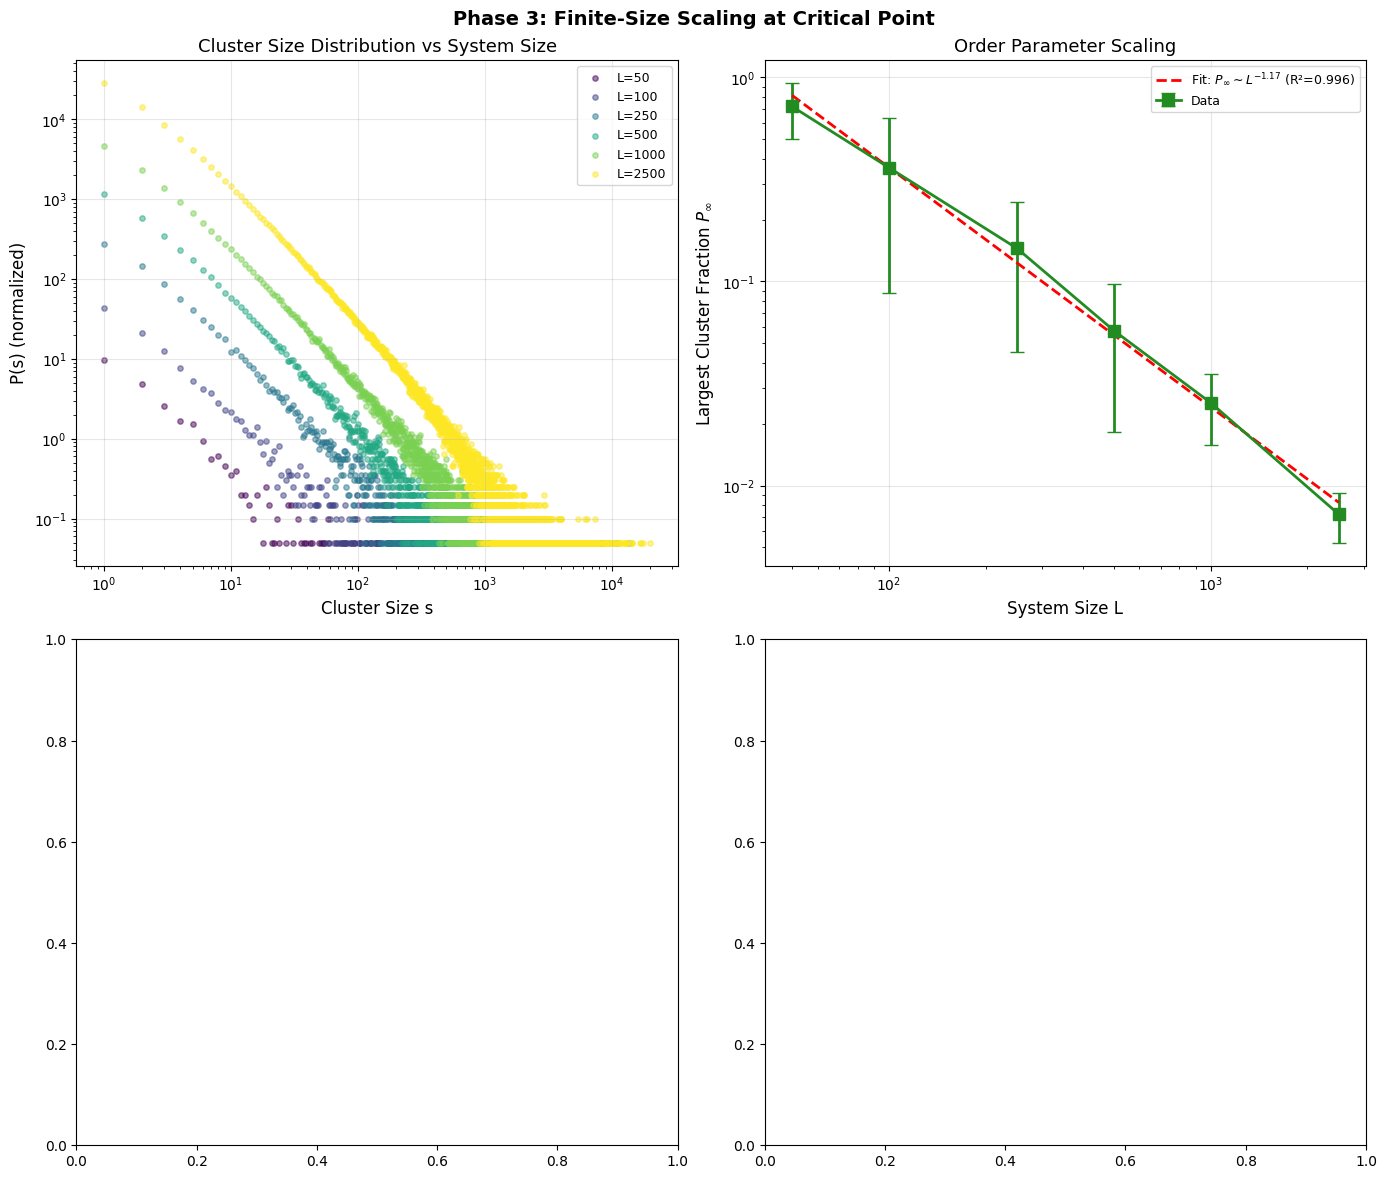

In [13]:
# Create the 4-panel FSS analysis figure
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle("Phase 3: Finite-Size Scaling at Critical Point", fontsize=14, fontweight='bold')

# Color map for different grid sizes
colors = plt.cm.viridis(np.linspace(0, 1, len(grid_sizes)))

# =============================================================================
# Panel 1: Cluster Size Distributions by Grid Size
# =============================================================================
ax = axes[0, 0]

for L, color in zip(grid_sizes, colors):
    clusters = np.array(data_by_L[L]['prey_clusters'])
    if len(clusters) == 0:
        continue
    clusters = clusters[clusters > 0]
    
    # Compute histogram
    sizes, counts = np.unique(clusters, return_counts=True)
    # Normalize
    n_replicates = len([r for r in results if r['grid_size'] == L])
    counts = counts / n_replicates
    
    ax.scatter(sizes, counts, alpha=0.5, s=15, color=color, label=f'L={L}')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Cluster Size s', fontsize=12)
ax.set_ylabel('P(s) (normalized)', fontsize=12)
ax.set_title('Cluster Size Distribution vs System Size', fontsize=13)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)


# =============================================================================
# Panel 2: Largest Cluster Fraction vs L
# =============================================================================
ax = axes[0, 1]

L_vals_frac = []
frac_mean = []
frac_std = []

for L in grid_sizes:
    fracs = data_by_L[L]['prey_largest_frac']
    if len(fracs) > 0:
        L_vals_frac.append(L)
        frac_mean.append(np.mean(fracs))
        frac_std.append(np.std(fracs))

L_vals_frac = np.array(L_vals_frac)
frac_mean = np.array(frac_mean)
frac_std = np.array(frac_std)

ax.errorbar(L_vals_frac, frac_mean, yerr=frac_std, fmt='s-', color='forestgreen',
            markersize=8, capsize=5, linewidth=2, label='Data')

# Fit power law
if len(L_vals_frac) >= 3:
    log_L = np.log10(L_vals_frac)
    log_frac = np.log10(frac_mean)
    slope_frac, intercept_frac, r_value_frac, _, _ = linregress(log_L, log_frac)
    
    fit_L = np.logspace(np.log10(L_vals_frac.min()), np.log10(L_vals_frac.max()), 50)
    fit_frac = 10**intercept_frac * fit_L**slope_frac
    ax.plot(fit_L, fit_frac, 'r--', linewidth=2,
            label=f'Fit: $P_{{\\infty}} \\sim L^{{{slope_frac:.2f}}}$ (R²={r_value_frac**2:.3f})')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('System Size L', fontsize=12)
ax.set_ylabel('Largest Cluster Fraction $P_\\infty$', fontsize=12)
ax.set_title('Order Parameter Scaling', fontsize=13)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Power-Law Fitting with p-values

Use the `powerlaw` package to rigorously test if cluster size distributions follow a power law.
For each grid size L, we:
1. Fit a power law to the cluster size distribution
2. Compare against alternative distributions (exponential, log-normal)
3. Extract p-values to assess goodness of fit


In [19]:
import powerlaw
from scipy.stats import kstest

# Store results for each grid size
powerlaw_results = []

print("Power-Law Fitting Results by Grid Size")
print("=" * 110)
print(f"{'L':<8} {'α (tau)':<10} {'x_min':<10} {'KS stat':<10} {'PL vs StrExp':<18} {'PL vs LN':<18} {'n_tail':<10}")
print("-" * 110)

for L in grid_sizes:
    clusters = np.array(data_by_L[L]['prey_clusters'])
    clusters = clusters[clusters > 0]  # Remove zeros
    
    if len(clusters) < 50:
        print(f"{L:<8} Insufficient data ({len(clusters)} points)")
        continue
    
    # Fit power law
    fit = powerlaw.Fit(clusters, discrete=True, verbose=False)
    
    # Get KS statistic (D) - this is the distance, not a method call
    ks_stat = fit.power_law.D
    
    # Compare power law vs alternatives
    # Positive R means power law is better, negative means alternative is better
    # p tells us if the difference is significant
    
    # vs Stretched Exponential (Weibull)
    R_strexp, p_strexp = fit.distribution_compare('power_law', 'stretched_exponential', normalized_ratio=True)
    
    # vs Lognormal
    R_ln, p_ln = fit.distribution_compare('power_law', 'lognormal', normalized_ratio=True)
    
    # Store results
    result = {
        'L': L,
        'alpha': fit.power_law.alpha,
        'xmin': fit.power_law.xmin,
        'ks_stat': ks_stat,
        'n_tail': int(np.sum(clusters >= fit.power_law.xmin)),
        'R_vs_strexp': R_strexp,
        'p_vs_strexp': p_strexp,
        'R_vs_ln': R_ln,
        'p_vs_ln': p_ln,
        'n_total': len(clusters)
    }
    powerlaw_results.append(result)
    
    # Format comparison results
    strexp_result = f"R={R_strexp:+.2f} (p={p_strexp:.3f})"
    ln_result = f"R={R_ln:+.2f} (p={p_ln:.3f})"
    
    print(f"{L:<8} {fit.power_law.alpha:<10.3f} {fit.power_law.xmin:<10.1f} {ks_stat:<10.4f} "
          f"{strexp_result:<18} {ln_result:<18} {result['n_tail']:<10}")

print("-" * 110)
print("\nInterpretation:")
print("  • α (tau): Power-law exponent P(s) ~ s^(-α)")
print("  • x_min: Lower bound where power law holds")
print("  • KS stat: Kolmogorov-Smirnov distance (lower = better fit)")
print("  • StrExp: Stretched exponential (Weibull) - common alternative to power law")
print("  • LN: Lognormal - often confused with power law in empirical data")
print("  • R>0 + p<0.05: Power law is SIGNIFICANTLY better than alternative")
print("  • R<0 + p<0.05: Alternative is SIGNIFICANTLY better than power law")
print("  • p>0.05: No significant difference between distributions")


Power-Law Fitting Results by Grid Size
L        α (tau)    x_min      KS stat    PL vs StrExp       PL vs LN           n_tail    
--------------------------------------------------------------------------------------------------------------


/opt/anaconda3/envs/clean_env/lib/python3.13/site-packages/powerlaw/distributions.py:776: UserWarning: No valid fits found for distribution stretched_exponential.
  warnings.warn(f"No valid fits found for distribution {self.name}.")


50       1.663      2.0        0.0298     R=+1.65 (p=0.100)  R=+0.78 (p=0.438)  363       


/opt/anaconda3/envs/clean_env/lib/python3.13/site-packages/powerlaw/distributions.py:776: UserWarning: No valid fits found for distribution stretched_exponential.
  warnings.warn(f"No valid fits found for distribution {self.name}.")


100      1.779      9.0        0.0267     R=-1.65 (p=0.100)  R=-1.84 (p=0.065)  654       


/opt/anaconda3/envs/clean_env/lib/python3.13/site-packages/powerlaw/distributions.py:776: UserWarning: No valid fits found for distribution stretched_exponential.
  warnings.warn(f"No valid fits found for distribution {self.name}.")


250      2.288      92.0       0.0203     R=-0.30 (p=0.761)  R=-0.85 (p=0.393)  666       


/opt/anaconda3/envs/clean_env/lib/python3.13/site-packages/powerlaw/distributions.py:776: UserWarning: No valid fits found for distribution stretched_exponential.
  warnings.warn(f"No valid fits found for distribution {self.name}.")


500      1.855      11.0       0.0320     R=-11.66 (p=0.000) R=-11.43 (p=0.000) 15646     


/opt/anaconda3/envs/clean_env/lib/python3.13/site-packages/powerlaw/distributions.py:776: UserWarning: No valid fits found for distribution stretched_exponential.
  warnings.warn(f"No valid fits found for distribution {self.name}.")


1000     2.863      1046.0     0.0218     R=-0.29 (p=0.769)  R=-0.78 (p=0.436)  450       
2500     2.744      786.0      0.0157     R=-1.89 (p=0.059)  R=-2.94 (p=0.003)  4304      
--------------------------------------------------------------------------------------------------------------

Interpretation:
  • α (tau): Power-law exponent P(s) ~ s^(-α)
  • x_min: Lower bound where power law holds
  • KS stat: Kolmogorov-Smirnov distance (lower = better fit)
  • StrExp: Stretched exponential (Weibull) - common alternative to power law
  • LN: Lognormal - often confused with power law in empirical data
  • R>0 + p<0.05: Power law is SIGNIFICANTLY better than alternative
  • R<0 + p<0.05: Alternative is SIGNIFICANTLY better than power law
  • p>0.05: No significant difference between distributions


/opt/anaconda3/envs/clean_env/lib/python3.13/site-packages/powerlaw/distributions.py:776: UserWarning: No valid fits found for distribution stretched_exponential.
  warnings.warn(f"No valid fits found for distribution {self.name}.")


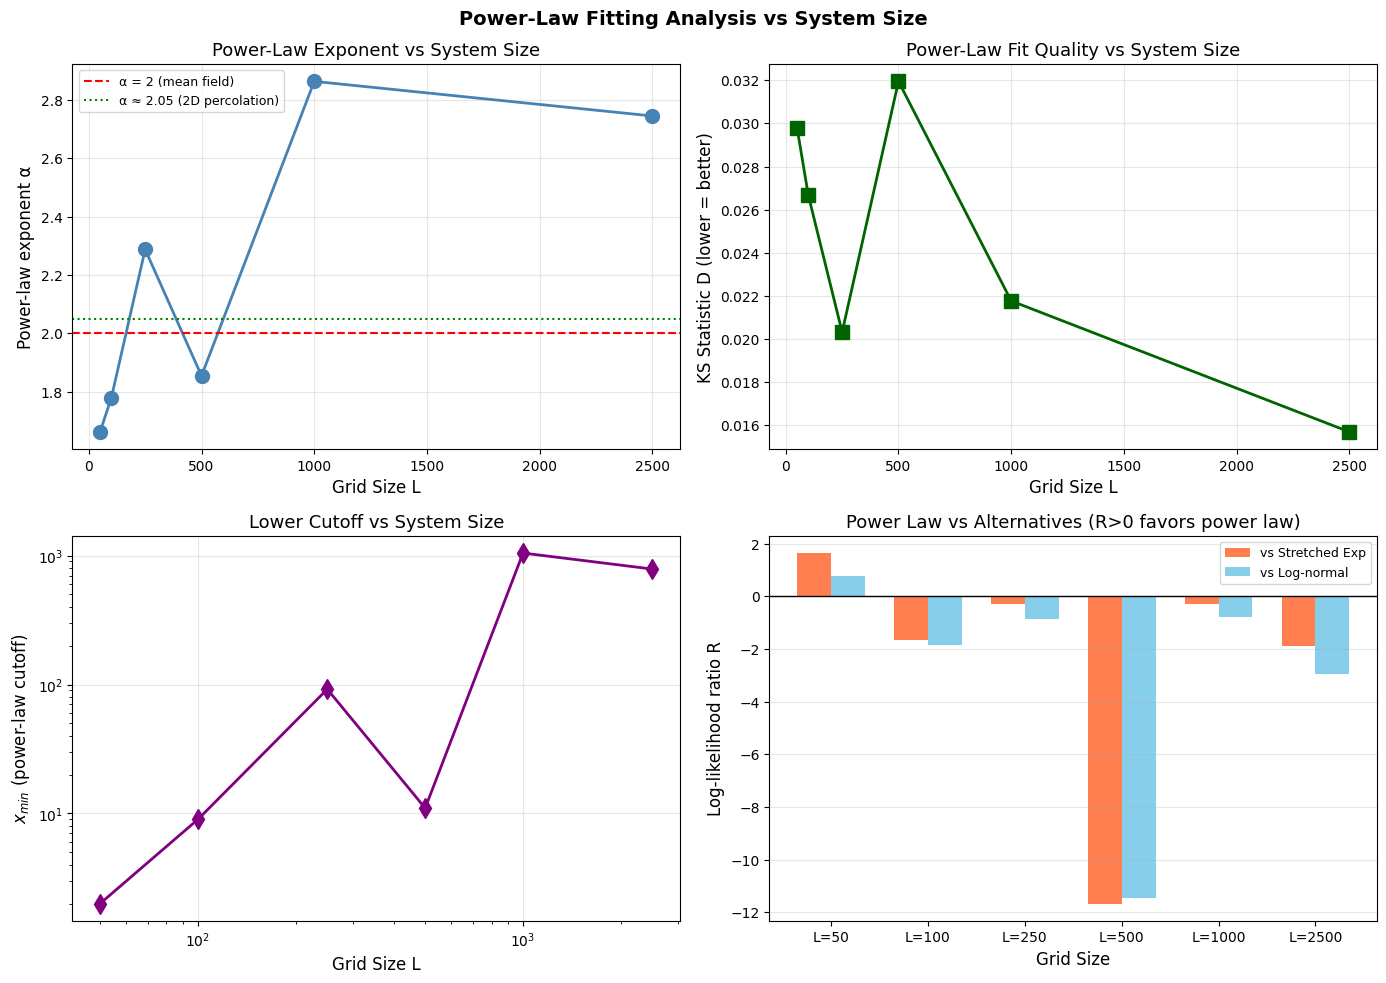

In [20]:
# Visualize power-law fitting results vs grid size
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Power-Law Fitting Analysis vs System Size", fontsize=14, fontweight='bold')

if powerlaw_results:
    L_arr = np.array([r['L'] for r in powerlaw_results])
    alpha_arr = np.array([r['alpha'] for r in powerlaw_results])
    ks_arr = np.array([r['ks_stat'] for r in powerlaw_results])
    xmin_arr = np.array([r['xmin'] for r in powerlaw_results])
    R_strexp_arr = np.array([r['R_vs_strexp'] for r in powerlaw_results])
    R_ln_arr = np.array([r['R_vs_ln'] for r in powerlaw_results])

    # Panel 1: Power-law exponent α vs L
    ax = axes[0, 0]
    ax.plot(L_arr, alpha_arr, 'o-', color='steelblue', markersize=10, linewidth=2)
    ax.axhline(2.0, color='red', linestyle='--', label='α = 2 (mean field)')
    ax.axhline(2.05, color='green', linestyle=':', label='α ≈ 2.05 (2D percolation)')
    ax.set_xlabel('Grid Size L', fontsize=12)
    ax.set_ylabel('Power-law exponent α', fontsize=12)
    ax.set_title('Power-Law Exponent vs System Size', fontsize=13)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    # Panel 2: KS statistic vs L (lower = better fit)
    ax = axes[0, 1]
    ax.plot(L_arr, ks_arr, 's-', color='darkgreen', markersize=10, linewidth=2)
    ax.set_xlabel('Grid Size L', fontsize=12)
    ax.set_ylabel('KS Statistic D (lower = better)', fontsize=12)
    ax.set_title('Power-Law Fit Quality vs System Size', fontsize=13)
    ax.grid(True, alpha=0.3)

    # Panel 3: x_min vs L
    ax = axes[1, 0]
    ax.loglog(L_arr, xmin_arr, 'd-', color='purple', markersize=10, linewidth=2)
    ax.set_xlabel('Grid Size L', fontsize=12)
    ax.set_ylabel('$x_{min}$ (power-law cutoff)', fontsize=12)
    ax.set_title('Lower Cutoff vs System Size', fontsize=13)
    ax.grid(True, alpha=0.3)

    # Panel 4: Likelihood ratio comparisons (Stretched Exp & Lognormal)
    ax = axes[1, 1]
    x = np.arange(len(L_arr))
    width = 0.35
    ax.bar(x - width/2, R_strexp_arr, width, label='vs Stretched Exp', color='coral')
    ax.bar(x + width/2, R_ln_arr, width, label='vs Log-normal', color='skyblue')
    ax.axhline(0, color='black', linewidth=1)
    ax.set_xticks(x)
    ax.set_xticklabels([f'L={L}' for L in L_arr])
    ax.set_xlabel('Grid Size', fontsize=12)
    ax.set_ylabel('Log-likelihood ratio R', fontsize=12)
    ax.set_title('Power Law vs Alternatives (R>0 favors power law)', fontsize=13)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


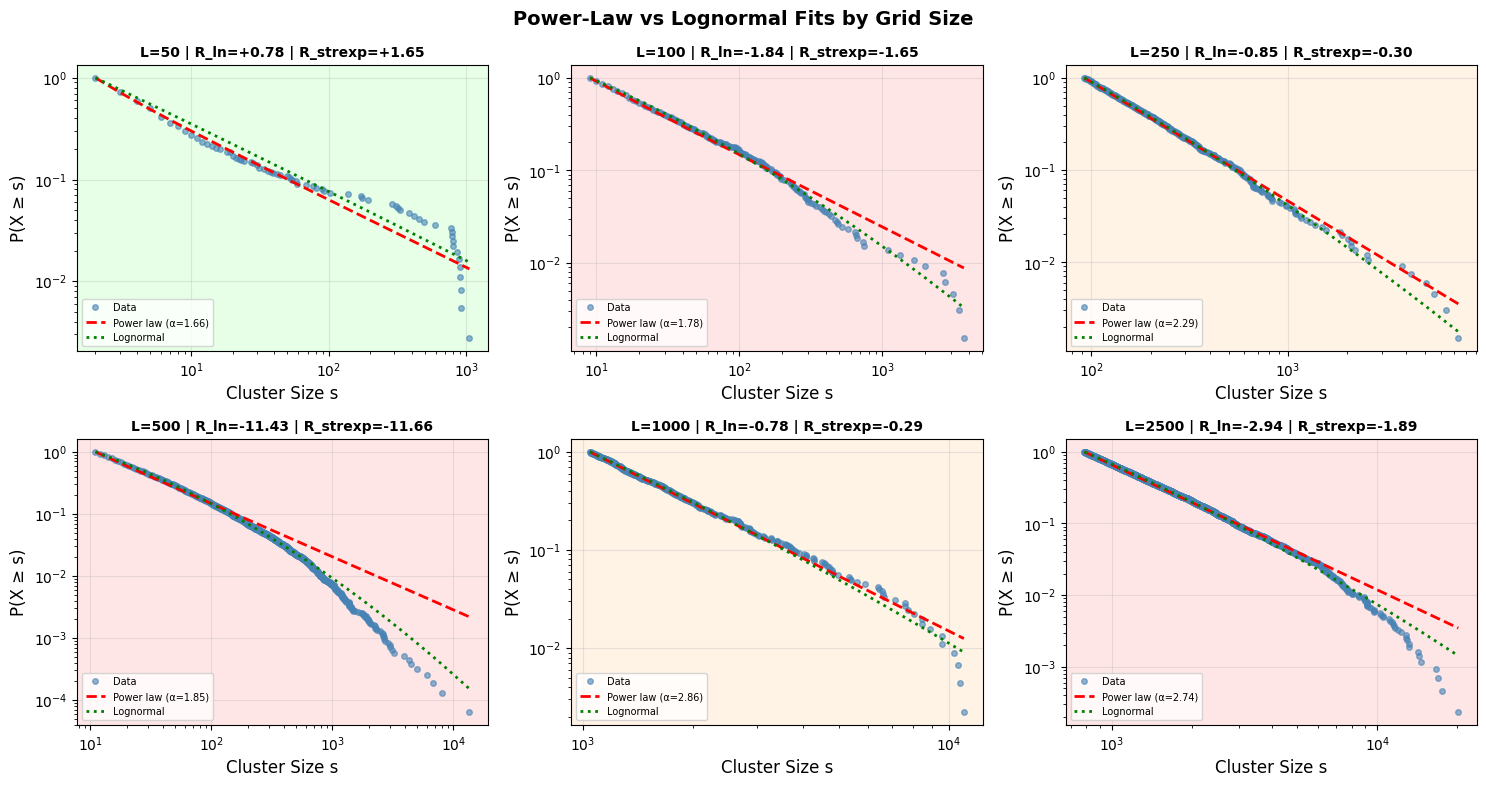


Color coding based on R vs Lognormal: Green = R>0 (power law), Orange = -1<R≤0, Red = R≤-1 (lognormal)


In [21]:
# Plot individual power-law fits with lognormal comparison for each grid size
n_sizes = len(grid_sizes)
n_cols = min(3, n_sizes)
n_rows = (n_sizes + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_sizes == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = axes.reshape(1, -1)
    
fig.suptitle("Power-Law vs Lognormal Fits by Grid Size", fontsize=14, fontweight='bold')

for idx, L in enumerate(grid_sizes):
    row, col = idx // n_cols, idx % n_cols
    ax = axes[row, col]
    
    clusters = np.array(data_by_L[L]['prey_clusters'])
    clusters = clusters[clusters > 0]
    
    if len(clusters) < 50:
        ax.text(0.5, 0.5, f'L={L}\nInsufficient data', ha='center', va='center', transform=ax.transAxes)
        ax.set_visible(False)
        continue
    
    # Fit power law
    fit = powerlaw.Fit(clusters, discrete=True, verbose=False)
    
    # Get result from our stored results
    result = next((r for r in powerlaw_results if r['L'] == L), None)
    
    # Plot CCDF (complementary cumulative distribution)
    fit.plot_ccdf(ax=ax, color='steelblue', linewidth=0, marker='o', markersize=4, alpha=0.6, label='Data')
    fit.power_law.plot_ccdf(ax=ax, color='red', linestyle='--', linewidth=2, label=f'Power law (α={fit.power_law.alpha:.2f})')
    
    # Also plot lognormal fit for comparison
    fit.lognormal.plot_ccdf(ax=ax, color='green', linestyle=':', linewidth=2, label='Lognormal')
    
    # Add fit info with R values for both comparisons
    R_ln = result['R_vs_ln'] if result else np.nan
    R_strexp = result['R_vs_strexp'] if result else np.nan
    ax.set_title(f'L={L} | R_ln={R_ln:+.2f} | R_strexp={R_strexp:+.2f}', fontsize=10, fontweight='bold')
    ax.set_xlabel('Cluster Size s')
    ax.set_ylabel('P(X ≥ s)')
    ax.legend(fontsize=7, loc='lower left')
    ax.grid(True, alpha=0.3)
    
    # Color code based on R vs lognormal (the more challenging comparison)
    # R > 0 means power law is favored over lognormal
    if result and R_ln > 0:
        ax.set_facecolor('#e6ffe6')  # Light green - power law favored
    elif result and R_ln > -1:
        ax.set_facecolor('#fff3e6')  # Light orange - marginal
    else:
        ax.set_facecolor('#ffe6e6')  # Light red - lognormal favored

# Hide unused subplots
for idx in range(n_sizes, n_rows * n_cols):
    row, col = idx // n_cols, idx % n_cols
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()

print("\nColor coding based on R vs Lognormal: Green = R>0 (power law), Orange = -1<R≤0, Red = R≤-1 (lognormal)")


In [22]:
# Summary: Does power-law fit improve with grid size?
print("=" * 85)
print("POWER-LAW FIT QUALITY vs GRID SIZE")
print("=" * 85)

if powerlaw_results:
    # Sort by L
    sorted_results = sorted(powerlaw_results, key=lambda x: x['L'])
    
    print(f"\n{'L':<8} {'α':<8} {'KS':<10} {'R_strexp':<12} {'R_ln':<12} {'Verdict (vs LN)':<25}")
    print("-" * 75)
    
    for r in sorted_results:
        # Use R vs lognormal to judge (more stringent test)
        R_ln = r['R_vs_ln']
        p_ln = r['p_vs_ln']
        R_strexp = r['R_vs_strexp']
        
        if R_ln > 0 and p_ln < 0.05:
            verdict = "✅ Power law (significant)"
        elif R_ln > 0:
            verdict = "✅ Power law (weak)"
        elif R_ln < 0 and p_ln < 0.05:
            verdict = "❌ Lognormal (significant)"
        else:
            verdict = "⚠️  Inconclusive"
        
        print(f"{r['L']:<8} {r['alpha']:<8.3f} {r['ks_stat']:<10.4f} {R_strexp:<+12.2f} {R_ln:<+12.2f} {verdict}")
    
    print("-" * 75)
    
    # Check if KS stat improves (decreases) with L
    L_vals = [r['L'] for r in sorted_results]
    ks_vals = [r['ks_stat'] for r in sorted_results]
    R_ln_vals = [r['R_vs_ln'] for r in sorted_results]
    R_strexp_vals = [r['R_vs_strexp'] for r in sorted_results]
    
    if len(L_vals) >= 3:
        from scipy.stats import spearmanr
        corr_ks, p_ks = spearmanr(L_vals, ks_vals)
        corr_R_ln, p_R_ln = spearmanr(L_vals, R_ln_vals)
        corr_R_strexp, p_R_strexp = spearmanr(L_vals, R_strexp_vals)
        
        print(f"\nCorrelations with grid size L:")
        print(f"  KS stat:        r = {corr_ks:+.3f} (p = {p_ks:.3f})")
        print(f"  R vs Lognormal: r = {corr_R_ln:+.3f} (p = {p_R_ln:.3f})")
        print(f"  R vs StretchExp: r = {corr_R_strexp:+.3f} (p = {p_R_strexp:.3f})")
        
        if corr_ks < -0.5 and p_ks < 0.1:
            print("\n→ KS stat DECREASES with L (fit improves)")
        elif corr_ks > 0.5 and p_ks < 0.1:
            print("\n→ KS stat INCREASES with L (fit worsens)")
        
        if corr_R_ln > 0.5 and p_R_ln < 0.1:
            print("→ Power law becomes MORE favored over lognormal at larger L")
        elif corr_R_ln < -0.5 and p_R_ln < 0.1:
            print("→ Lognormal becomes MORE favored over power law at larger L")
    
    # Mean exponent
    alpha_mean = np.mean([r['alpha'] for r in sorted_results])
    alpha_std = np.std([r['alpha'] for r in sorted_results])
    print(f"\nMean power-law exponent: α = {alpha_mean:.3f} ± {alpha_std:.3f}")
    print(f"  (2D percolation: τ ≈ 2.05, Mean field: τ = 2.0)")

print("=" * 85)


POWER-LAW FIT QUALITY vs GRID SIZE

L        α        KS         R_strexp     R_ln         Verdict (vs LN)          
---------------------------------------------------------------------------
50       1.663    0.0298     +1.65        +0.78        ✅ Power law (weak)
100      1.779    0.0267     -1.65        -1.84        ⚠️  Inconclusive
250      2.288    0.0203     -0.30        -0.85        ⚠️  Inconclusive
500      1.855    0.0320     -11.66       -11.43       ❌ Lognormal (significant)
1000     2.863    0.0218     -0.29        -0.78        ⚠️  Inconclusive
2500     2.744    0.0157     -1.89        -2.94        ❌ Lognormal (significant)
---------------------------------------------------------------------------

Correlations with grid size L:
  KS stat:        r = -0.543 (p = 0.266)
  R vs Lognormal: r = -0.486 (p = 0.329)
  R vs StretchExp: r = -0.486 (p = 0.329)

Mean power-law exponent: α = 2.199 ± 0.470
  (2D percolation: τ ≈ 2.05, Mean field: τ = 2.0)
